# Topic Modeling and NLP
# - using the State of the Union Addresses from 1913 - 2017 (with some omissions)

## - Loading libraries

In [508]:
import os
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from gensim import corpora
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from time import time
import logging
import seaborn as sns

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

### set directory with text files
### strip '.txt' ending from file names

In [178]:
path = '/Users/scott/coding/state_union/text/'
files = pd.Series(sorted(os.listdir(path))).map(lambda x: x[:-4])

### function to grab the content from the text files

In [179]:
def get_text_dict():
    txtdict = {}

    for file in files:
        filetxt = []        
        file_f = path + file
        
        try:
            file_ = path + file + '.txt'
            f = open(file_,encoding='utf8',errors='ignore')
            filetxt.append(f.readline())
            txtdict[file] = filetxt[0]
        except:
            print('exception!')
    return(txtdict)

### create a dictionary of text called text!

In [180]:
text = get_text_dict()

### pretty standard NLP prep-work
### - set stopwords
### - set punctuation
### - initialize lemmatizer
### - split text into lower-case tokens
### - drop punctuation
### - apply lemmatization

In [187]:
stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()
newstop = set(list(stopwords) + ['u','it','shall','every','make'])

def cleaning(article):
    lower_split = " ".join([i for i in article.lower().split() if i not in newstop])
    drop_punct = "".join(i for i in lower_split if i not in punctuation)
    cleaned = " ".join(lemmatize.lemmatize(i) for i in drop_punct.split())
    return (cleaned)

## clean the text!

In [181]:
text_ = pd.Series(text)
text = text_.map(cleaning)

## split strings into words

In [182]:
text_list = [i.split() for i in text]

### create data frame of content
### add columns of document word count/length values
### display first 10 values

In [641]:
content_df = pd.DataFrame(pd.Series(text),columns=['words'])
content_df["num_words"] = content_df['words'].map(lambda x: len(x.split()))
content_df['avg_word_length'] = content_df['words'].map(lambda x: len(x)/len(x.split()))
content_df.head(10)

,words,num_words,avg_word_length
1913,gentleman congressin pursuance constitutional ...,1631,7.667689
1914,gentleman congress session upon entering closi...,2051,7.336421
1915,gentleman congress since last privilege addres...,3755,7.517976
1916,gentleman congress fulfilling time duty laid u...,999,8.215215
1917,gentleman congresseight month elapsed since la...,1752,7.417237
1918,gentleman congress year elapsed since last sto...,2516,7.511526
1921,mr speaker member congress gratifying privileg...,2780,8.120504
1922,member congress many problem calling solution ...,2940,8.120408
1923,since close last congress nation lost presiden...,3341,8.116133
1934,mr president mr speaker senator representative...,1127,7.921917


### build a dictionary corpus
### save files to disk

In [ ]:

dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')
print (dictionary)

### build a doc term matrix using bag of words model
### save corpus to disk

In [490]:
# creating doc_term_matrix with bag of words model
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

print ('The number of documents in the corpus is %d'%(len(doc_term_matrix)))

The number of documents in the corpus is 89


# Topic Modeling
## Prepare Lda model with gensim
## - train model with corpus = doc_term_matrix, id2word = dictionary, and num_topics = 3

In [580]:
# Lda model object
Lda = gensim.models.ldamodel.LdaModel
print('this may take a while...')

#train model
ldamodel = Lda(doc_term_matrix, random_state=0, num_topics=5, id2word = dictionary, passes=50)


this may take a while...


### Display the topics

In [582]:
print(ldamodel.print_topics(num_topics=5, num_words=5))

[(0, '0.011*"year" + 0.009*"nation" + 0.008*"world" + 0.008*"new" + 0.008*"must"'), (1, '0.002*"wrong" + 0.002*"people" + 0.002*"german" + 0.002*"master" + 0.001*"upon"'), (2, '0.009*"must" + 0.009*"nation" + 0.007*"government" + 0.007*"people" + 0.006*"world"'), (3, '0.011*"american" + 0.010*"year" + 0.009*"america" + 0.008*"people" + 0.007*"must"'), (4, '0.005*"would" + 0.004*"american" + 0.004*"may" + 0.004*"government" + 0.004*"problem"')]


## Save model

In [583]:
ldamodel.save('topic.model')

### Load model

In [584]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

## single function to prepare new text

In [585]:
def prep_new(txt):
    prep_txt = cleaning(txt).split()
    vectorized_txt = dictionary.doc2bow(prep_txt)
    return (vectorized_txt)

prep_new('new article that to be classified by trained model!')

[(175, 1), (971, 1), (1349, 1), (2146, 1), (4405, 1)]

In [586]:
data = {}
topics_ = {}
for i in text.keys().tolist():
    f_ = 'text/' + str(i) + '.txt'
    f = open(f_, encoding='utf8',errors='ignore')
    su_current = f.readline()
    topics_[i] = loading[(prep_new(su_current))]


### 2017 Trump State of the Union Topics

In [587]:
t.loc[88]

year                                             2017
topics    [(2, 0.0104987331275), (3, 0.981768704171)]
t_0                                                 0
t_1                                                 0
t_2                                              0.01
t_3                                             0.982
t_4                                                 0
t_5                                             0.405
Name: 88, dtype: object

### setting up additional data for data frame.
#### splitting tuples of topics to separate column by index

In [588]:
topic_cols = ['t_' + str(i) for i in range(10)]
t_0 = np.zeros(89)
t_1 = np.zeros(89)
t_2 = np.zeros(89)
t_3 = np.zeros(89)
t_4 = np.zeros(89)
#t_5 = np.zeros(89)
#t_6 = np.zeros(89)
#t_7 = np.zeros(89)
#t_8 = np.zeros(89)
#t_9 = np.zeros(89)

for i in range(len(t['year'])):
    tups = t['topics'][i]
    for tup in tups:
        ind_,val_ = tup
        if int(ind_) == 0:
            t_0[i] = round(val_,3)
        elif int(ind_) == 1:
            t_1[i] = round(val_,3)
        elif int(ind_) == 2:
            t_2[i] = round(val_,3)
        elif int(ind_) == 3:
            t_3[i] = round(val_,3)
        elif ind_ == 4:
            t_4[i] = round(val_,3)
        #elif ind_ == 5:
        #    t_5[i] = round(val_,3)
        #elif ind_ == 6:
        #    t_6[i] = round(val_,3)
        #elif ind_ == 7:
        #    t_7[i] = round(val_,3)
        #elif ind_ == 8:
        #    t_8[i] = round(val_,3)
        #elif ind_ == 9:
        #    t_9[i] = round(val_,3)

### putting it all together

In [589]:
t = pd.DataFrame(pd.Series(topics_),columns=['topics'])
t['topics'].map(lambda x: x)
t = t.reset_index()
t.columns = ['year','topics']
t['t_0'] = t_0
t['t_1'] = t_1
t['t_2'] = t_2
t['t_3'] = t_3
t['t_4'] = t_4
#t['t_5'] = t_5
#t['t_6'] = t_6
#t['t_7'] = t_7
#t['t_8'] = t_8
#t['t_9'] = t_9

t.head(20)

,year,topics,t_0,t_1,t_2,t_3,t_4
0,1913,"[(1, 0.243375702044), (2, 0.756237377168)]",0.000,0.490,0.510,0.000,0.000
1,1914,"[(2, 0.99958381909)]",0.000,0.000,1.000,0.000,0.000
2,1915,"[(2, 0.536093007383), (4, 0.463621949055)]",0.000,0.000,0.364,0.000,0.634
3,1916,"[(2, 0.999175850849)]",0.000,0.000,0.999,0.000,0.000
4,1917,"[(1, 0.274562080866), (2, 0.725079004371)]",0.000,0.521,0.478,0.000,0.000
5,1918,"[(2, 0.999667509055)]",0.000,0.000,1.000,0.000,0.000
6,1921,"[(2, 0.256324026071), (4, 0.743452907205)]",0.000,0.000,0.100,0.000,0.900
7,1922,"[(2, 0.210718500679), (4, 0.784395715757)]",0.000,0.000,0.066,0.000,0.931
8,1923,"[(2, 0.999753395511)]",0.000,0.000,1.000,0.000,0.000
9,1934,"[(2, 0.999269606733)]",0.000,0.000,0.999,0.000,0.000


## putting it all together...

In [590]:
dft = t[['year','t_0','t_1','t_2','t_3','t_4']]#,'t_5','t_6','t_7','t_8','t_9']]
dft

,year,t_0,t_1,t_2,t_3,t_4
0,1913,0.000,0.490,0.510,0.000,0.000
1,1914,0.000,0.000,1.000,0.000,0.000
2,1915,0.000,0.000,0.364,0.000,0.634
3,1916,0.000,0.000,0.999,0.000,0.000
4,1917,0.000,0.521,0.478,0.000,0.000
5,1918,0.000,0.000,1.000,0.000,0.000
6,1921,0.000,0.000,0.100,0.000,0.900
7,1922,0.000,0.000,0.066,0.000,0.931
8,1923,0.000,0.000,1.000,0.000,0.000
9,1934,0.000,0.000,0.999,0.000,0.000


## build stacked bar chart with matplotlib

(0.625, 90.125)

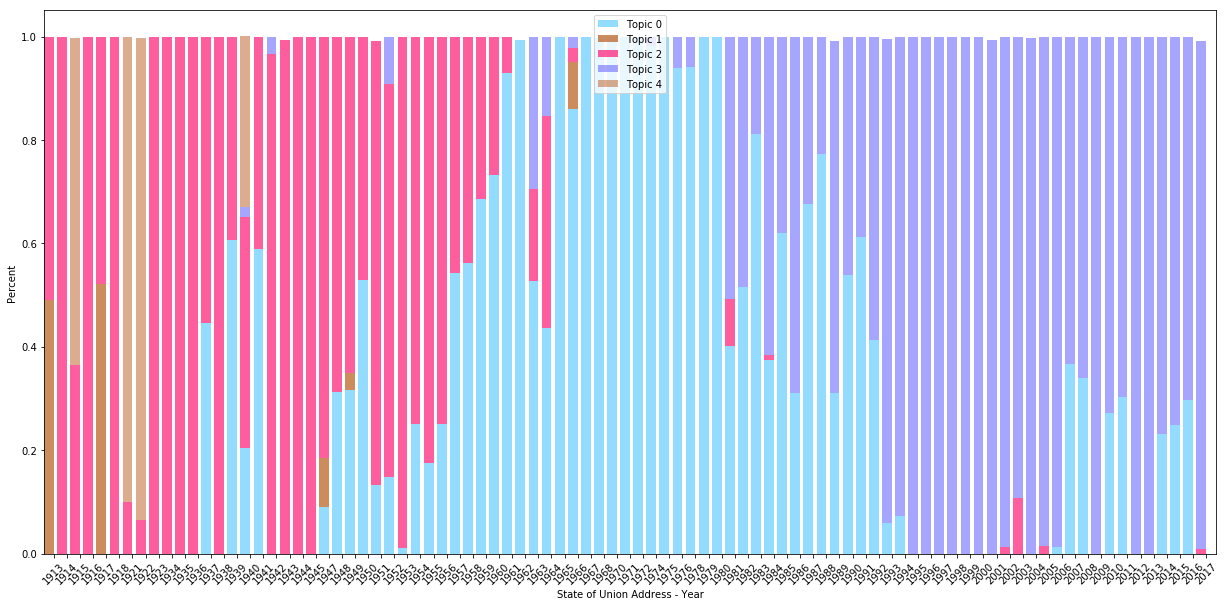

In [640]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(21,10))

# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(dft))]

# positions of the x-axis ticks (center of the bars)
tick_pos = [i+(bar_width/2) for i in bar_l]

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        dft['t_0'],
        width=bar_width,
        label='Topic 0',
        alpha=0.7,
        color='#66ccff')
ax1.bar(bar_l,
        dft['t_1'],
        width=bar_width,
        label='Topic 1',
        alpha=0.7,
        bottom=dft['t_0'],
        color='#B85C1A')#80bfff')
ax1.bar(bar_l,
        dft['t_2'],
        width=bar_width,
        label='Topic 2',
        alpha=0.7,
        bottom=[i+j for i,j in zip(dft['t_0'],dft['t_1'])],
        color='#ff1a75')#8080ff')
ax1.bar(bar_l,
        dft['t_3'],
        width=bar_width,
        label='Topic 3',
        alpha=0.7,
        bottom=[i+j+k for i,j,k in zip(dft['t_0'],dft['t_1'],dft['t_2'])],
        color='#8080ff')#bf80ff')
ax1.bar(bar_l,
        dft['t_4'],
        width=bar_width,
        label='Topic 4',
        alpha=0.5,
        bottom=[i+j+k+l for i,j,k,l in zip(dft['t_0'],dft['t_1'],dft['t_2'],dft['t_3'])],
        color='#B85C1F')
#ax1.bar(bar_l,
#        dft['t_5'],
#        width=bar_width,
##        label='Topic 5',
#        alpha=0.5,
#        bottom=[i+j+k+l+m for i,j,k,l,m in zip(dft['t_0'],dft['t_1'],dft['t_2'],dft['t_3'],dft['t_4'])],
#        color='')
#ax1.bar(bar_l,
#        dft['t_6'],
#        width=bar_width,
#        label='Topic 6',
#        alpha=0.5,
#        bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(dft['t_0'],dft['t_1'],dft['t_2'],dft['t_3'],dft['t_4'],dft['t_5'])],
#        color='')
#ax1.bar(bar_l,
#        dft['t_7'],
#        width=bar_width,
#        label='Topic 7',
#        alpha=0.5,
#        bottom=[i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(dft['t_0'],dft['t_1'],dft['t_2'],dft['t_3'],dft['t_4'],dft['t_5'],dft['t_6'])],
#        color='#ff5050')
#ax1.bar(bar_l,
#        dft['t_8'],
#        width=bar_width,
#        label='Topic 8',
#        alpha=0.5,
#        bottom=[i+j+k+l+m+n+o+p for i,j,k,l,m,n,o,p in zip(dft['t_0'],dft['t_1'],dft['t_2'],dft['t_3'],dft['t_4'],dft['t_5'],dft['t_6'],dft['t_7'])],
#        color='#ff5050')
#ax1.bar(bar_l,
#        dft['t_9'],
#        width=bar_width,
#        label='Topic 9',
#        alpha=0.5,
#        bottom=[i+j+k+l+m+n+o+p+q for i,j,k,l,m,n,o,p,q in zip(dft['t_0'],dft['t_1'],dft['t_2'],dft['t_3'],dft['t_4'],dft['t_5'],dft['t_6'],dft['t_7'],dft['t_8'])],
#        color='#B85C1A')

# set the x ticks with names
plt.xticks(tick_pos, dft['year'])

# Set label and legend
ax1.set_ylabel("Percent")
ax1.set_xlabel("State of Union Address - Year")
plt.legend(loc='upper center')

ax1.set_xticklabels(dft['year'], rotation=45)
# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
#f.autofmt_xdate()

In [592]:
vis_data = gensimvis.prepare(ldamodel,doc_term_matrix,dictionary)
pyLDAvis.display(vis_data)

/Users/scott/Library/Python/3.6/lib/python/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [593]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import random


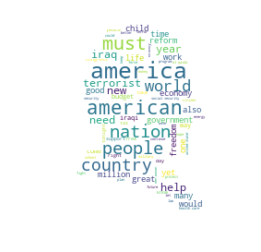

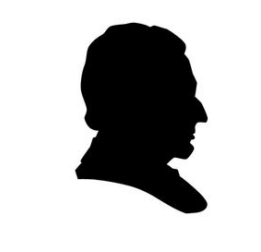

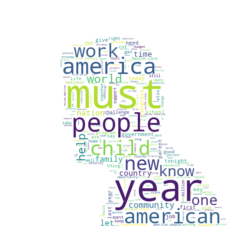

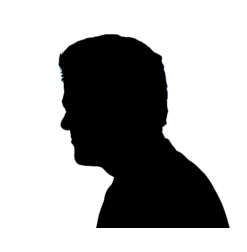

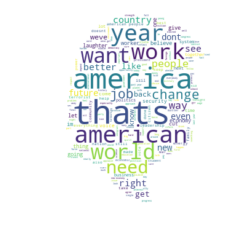

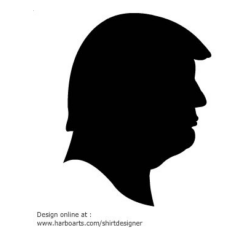

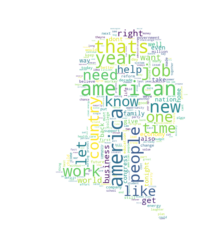

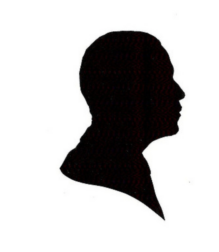

In [637]:
from wordcloud import WordCloud, STOPWORDS

#d = path.dirname(_file_)
d = os.getcwd()
# Read the whole text.
#text = open(path.join(d, 'alice.txt')).read()

obama_txt = ' '.join(text[80:-1].values)
trump_txt = text[~1]
gwbush_txt =' '.join(text[72:80].values)
clinton_txt = ' '.join(text[64:72])

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
trump_mask = np.array(Image.open(path.join(d, "trumphead.png")))
obama_mask = np.array(Image.open(path.join(d,"obamahead2.png")))
gwbush_mask = np.array(Image.open(path.join(d, "bushhead.png")))
clinton_mask = np.array(Image.open(path.join(d, "clintonh3.png")))

wcg = WordCloud(background_color="white", max_words=2000, mask=gwbush_mask, stopwords=newstop)
# generate word cloud
wcg.generate(gwbush_txt)

# store to file
wcg.to_file(path.join(d, "gwbush.png"))


wcc = WordCloud(background_color="white", max_words=2000, mask=clinton_mask, stopwords=newstop)
# generate word cloud
wcc.generate(clinton_txt)

# store to file
wcc.to_file(path.join(d, "clinton.png"))


                      
wct = WordCloud(background_color="white", max_words=2000, mask=trump_mask, stopwords=newstop)
# generate word cloud
wct.generate(trump_txt)

# store to file
wct.to_file(path.join(d, "trump.png"))
                      
                      
wco = WordCloud(background_color="white", max_words=2000, mask=obama_mask, stopwords=newstop)
# generate word cloud
wco.generate(obama_txt)

# store to file
wco.to_file(path.join(d, "obama.png"))



# show

plt.imshow(wcg, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(gwbush_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.imshow(wcc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(clinton_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
            

plt.imshow(wct, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(trump_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
                      
plt.imshow(wco, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(obama_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()                      
                      

In [622]:
os.listdir()

['#analyze_text.py#',
 '.#analyze_text.py',
 '.DS_Store',
 '.git',
 '.ipynb_checkpoints',
 '__pycache__',
 'analyze_text.py',
 'analyze_text.py~',
 'corpus.mm',
 'corpus.mm.index',
 'dictionary.dict',
 'get_state_unions.py',
 'get_state_unions.pyc',
 'obamahead.jpg',
 'obamahead.png',
 'README.md',
 'running.log',
 'su-scrape.py',
 'SU_Topic_modeling_visualized.ipynb',
 'text',
 'topic.model',
 'topic.model.expElogbeta.npy',
 'topic.model.id2word',
 'topic.model.state',
 'trumphead.jpg',
 'trumphead.png']

In [602]:
O = text[79:-1]

In [632]:
text[80:-1].values

array([ 'madam speaker mr vice president member congress first lady united statesshes around somewhere come tonight address distinguished men woman great chamber speak frankly directly men woman sent u here know many american watching right now state economy concern rise others rightly so havent personally affected recession probably know someone ha friend neighbor member family dont need hear another list statistic know economy crisis live day it worry wake source sleepless night it job thought youd retire lost business built dream upon thats hanging thread college acceptance letter child put back envelope impact recession real everywhere economy may weakened confidence shaken though living difficult uncertain time tonight want american know this rebuild recover united state america emerge stronger before weight crisis determine destiny nation answer problem dont lie beyond reach exist laboratory university field factory imagination entrepreneur pride hardest working people earth qual

In [635]:
len(text[64:72])

8